In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.manual_seed(55)

### Lenet 구성하기

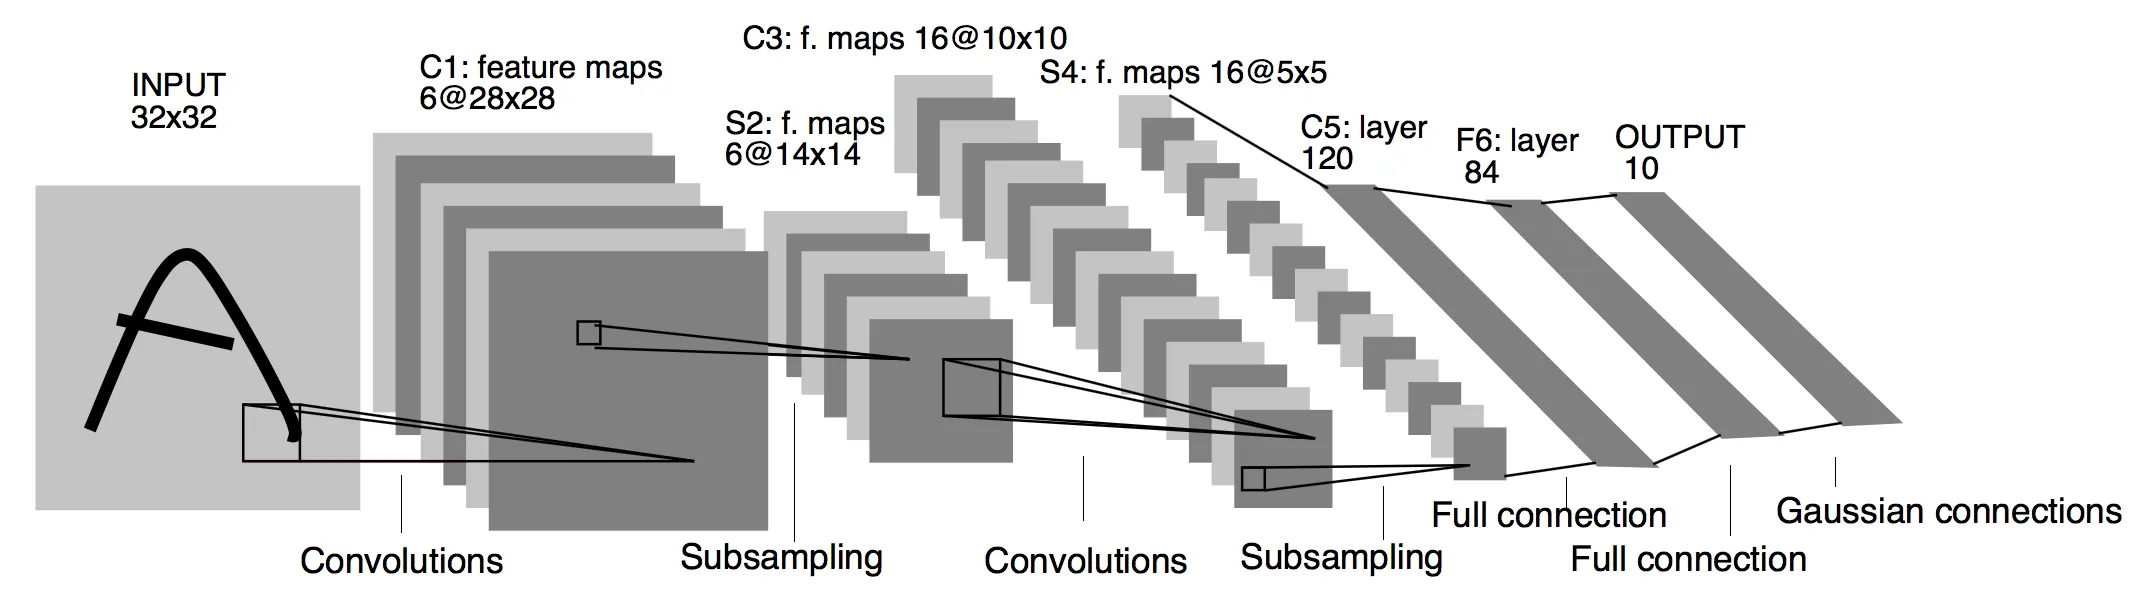

In [2]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 3개의 입력 이미지 채널, 6개의 출력 특징 맵, 5X5 합성곱 커널
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6개의 입력 이미지 채널, 16개의 출력 특징 맵, 5X5 합성곱 커널
        self.cn2 = nn.Conv2d(6, 16, 5)
        # 크기 120, 84, 10의 완전 연결 계층
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5는 이 계층의 공간 차원
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 5X5 커널과 합성곱
        x = F.relu(self.cn1(x))
        
        # (2,2) 윈도우에 Max 풀링
        x = F.max_pool2d(x, (2, 2))
        
        # 5X5 커널과 합성곱
        x = F.relu(self.cn2(x))
        
        # (2,2) 윈도우에 Max 풀링
        x = F.max_pool2d(x, (2, 2))
        
        # 공간 및 깊이 차원을 단일 벡터로 flatten-> 완전 연결 계층의 입력으로 사용
        x = x.view(-1, self.flattened_features(x)) # 텐서를 (?, self.flattened_features(x))의 크기로 변경
        
        # 완전 연결 수행
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # 배치차원은 연산에서 제외
        size = x.size()[1:]  
        # (배치size, 채널size, 이미지size, 이미지size)
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats


lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 학습 및 테스트 함수 정의

In [3]:
def train(net, trainloader, optim, epoch):
    # loss 초기화
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # input을 가져옴, [입력, 레이블]의 리스트
        # ip는 입력이미지, ground_truth는 ip가 속한 이미지의 출력 클래스
        ip, ground_truth = data

        # 매개변수인 경사를 0으로 초기화
        optim.zero_grad()

        # 순전파 + 역전파 + 최적화
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # loss 업데이트
        loss_total += loss.item()
        
        # loss 확인
        if (i+1) % 1000 == 0:    # 배치 1000마다 출력 
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

In [4]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

### 데이터 로드
CIFAR-10 데이터셋으로 10개의 클래스에 대해 레이블이 있는 32X32 RGB 이미지 6만 개이다.
- 5만개 훈련셋
- 1만개 테스트셋

In [5]:
# 픽셀값은 0-1 사이이므로 픽셀 값을 정규화하기 위해 평균과 표준편차를 0.5로 유지
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=1)


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)


# 순서 주의해야함
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


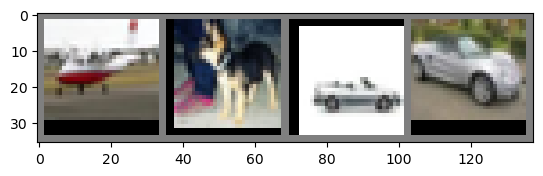

    plane  ||  dog  ||  car  ||  car


In [6]:
# 이미지 표시하는 함수를 정의
def imageshow(image):
    # 이미지를 비정규화
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# 훈련 데이터셋의 샘플이미지
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 그리드에 이미지 표시
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# 레이블 출력
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

각각의 이미지에 맞게 레이블이 되어있음

### Lenet 훈련

In [7]:
# optimizer 정의 -> Adam
optim = torch.optim.Adam(lenet.parameters(), lr=0.001)

# 훈련시키는 loop 문
for epoch in range(50):  
    # 앞서 정의한 train,test 사용
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 9.792
[Epoch number : 1, Mini-batches:  2000] loss: 8.755
[Epoch number : 1, Mini-batches:  3000] loss: 8.315
[Epoch number : 1, Mini-batches:  4000] loss: 8.035
[Epoch number : 1, Mini-batches:  5000] loss: 7.754
[Epoch number : 1, Mini-batches:  6000] loss: 7.611

LeNet accuracy on 10000 images from test dataset: 48 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.246
[Epoch number : 2, Mini-batches:  2000] loss: 7.274
[Epoch number : 2, Mini-batches:  3000] loss: 7.088
[Epoch number : 2, Mini-batches:  4000] loss: 7.175
[Epoch number : 2, Mini-batches:  5000] loss: 7.067
[Epoch number : 2, Mini-batches:  6000] loss: 6.977

LeNet accuracy on 10000 images from test dataset: 55 %

[Epoch number : 3, Mini-batches:  1000] loss: 6.823
[Epoch number : 3, Mini-batches:  2000] loss: 6.787
[Epoch number : 3, Mini-batches:  3000] loss: 6.699
[Epoch number : 3, Mini-batches:  4000] loss: 6.628
[Epoch number : 3, Mini-batches:  5000] loss: 6.680
[E

[Epoch number : 23, Mini-batches:  1000] loss: 5.478
[Epoch number : 23, Mini-batches:  2000] loss: 5.328
[Epoch number : 23, Mini-batches:  3000] loss: 5.257
[Epoch number : 23, Mini-batches:  4000] loss: 5.322
[Epoch number : 23, Mini-batches:  5000] loss: 5.272
[Epoch number : 23, Mini-batches:  6000] loss: 5.181

LeNet accuracy on 10000 images from test dataset: 65 %

[Epoch number : 24, Mini-batches:  1000] loss: 5.323
[Epoch number : 24, Mini-batches:  2000] loss: 5.251
[Epoch number : 24, Mini-batches:  3000] loss: 5.241
[Epoch number : 24, Mini-batches:  4000] loss: 5.386
[Epoch number : 24, Mini-batches:  5000] loss: 5.314
[Epoch number : 24, Mini-batches:  6000] loss: 5.183

LeNet accuracy on 10000 images from test dataset: 66 %

[Epoch number : 25, Mini-batches:  1000] loss: 5.167
[Epoch number : 25, Mini-batches:  2000] loss: 5.231
[Epoch number : 25, Mini-batches:  3000] loss: 5.370
[Epoch number : 25, Mini-batches:  4000] loss: 5.349
[Epoch number : 25, Mini-batches:  500


LeNet accuracy on 10000 images from test dataset: 66 %

[Epoch number : 45, Mini-batches:  1000] loss: 4.981
[Epoch number : 45, Mini-batches:  2000] loss: 5.122
[Epoch number : 45, Mini-batches:  3000] loss: 5.121
[Epoch number : 45, Mini-batches:  4000] loss: 5.145
[Epoch number : 45, Mini-batches:  5000] loss: 5.101
[Epoch number : 45, Mini-batches:  6000] loss: 5.094

LeNet accuracy on 10000 images from test dataset: 67 %

[Epoch number : 46, Mini-batches:  1000] loss: 5.040
[Epoch number : 46, Mini-batches:  2000] loss: 5.151
[Epoch number : 46, Mini-batches:  3000] loss: 5.146
[Epoch number : 46, Mini-batches:  4000] loss: 5.094
[Epoch number : 46, Mini-batches:  5000] loss: 5.091
[Epoch number : 46, Mini-batches:  6000] loss: 5.076

LeNet accuracy on 10000 images from test dataset: 66 %

[Epoch number : 47, Mini-batches:  1000] loss: 4.982
[Epoch number : 47, Mini-batches:  2000] loss: 5.085
[Epoch number : 47, Mini-batches:  3000] loss: 5.004
[Epoch number : 47, Mini-batches: 

In [8]:
# 모델파일을 저장
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

### Lenet 테스트

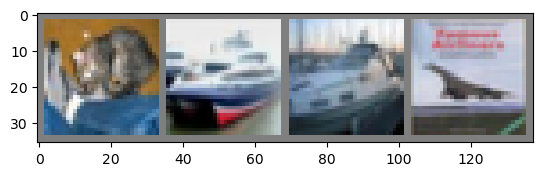

Label:         cat  ship  ship plane
Prediction:    cat   car truck plane


In [9]:
# 테스트 데이터셋 이미지 로딩
d_iter = iter(testloader)
im, ground_truth = d_iter.next()

# 이미지와 실제값 출력
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# 모델 로딩
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# 모델 추론
op = lenet_cached(im)

# 예측 결과 출력
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

모델의 전반적인 정확도

In [10]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 53 %


클래스별 정확도 확인

In [11]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 62 %
Model accuracy for class   car : 68 %
Model accuracy for class  bird : 32 %
Model accuracy for class   cat : 39 %
Model accuracy for class  deer : 50 %
Model accuracy for class   dog : 35 %
Model accuracy for class  frog : 66 %
Model accuracy for class horse : 57 %
Model accuracy for class  ship : 58 %
Model accuracy for class truck : 65 %


성능이 좋지는 않지만 임의로 선택하는 확률인 10%보다는 훨씬 좋은 성능을 보인다